In [1]:
# setting up the notebook width to 100% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. import libraries

In [2]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint

## 2. load data

In [3]:
df = pd.read_csv("./creditcard.csv")

## 3. data cleaning

In [4]:
df.shape

(284807, 31)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 3.1 check data types consistency

In [6]:
df.dtypes.value_counts()

float64    30
int64       1
Name: count, dtype: int64

No strings in the dataset hence no string pre-processing needed

### 3.2 check null values and column types¶

In [7]:
df.info(show_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#### 3.2.1 confirm that there are no null values

In [8]:
df.isnull().any(axis=0)

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

### 3.3 check for duplicates

In [9]:
print(f"{len(df[df.duplicated()])} entries are duplicates")

1081 entries are duplicates


#### 3.3.1 remove duplicates

In [10]:
print(f"{len(df)} number of data points including duplicates")
df = df.drop_duplicates().reset_index(drop=True)
print(f"{len(df)} number of data points excluding duplicates")

284807 number of data points including duplicates
283726 number of data points excluding duplicates


## 4. data analysis and feature extraction

### 4.1 univariate analysis

In [11]:
df.Class.value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

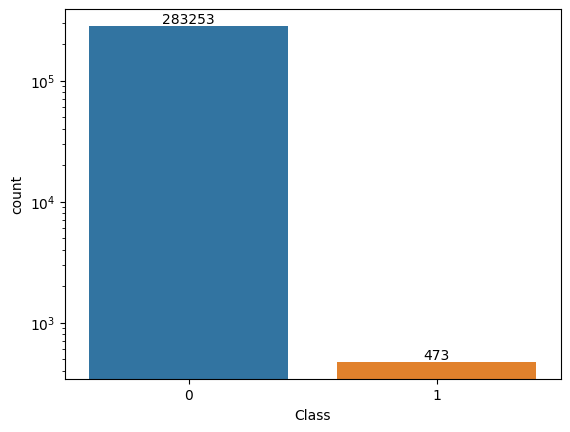

In [12]:
ax=sns.countplot(data=df, x='Class');
ax.bar_label(ax.containers[0])
ax.set_yscale('log')

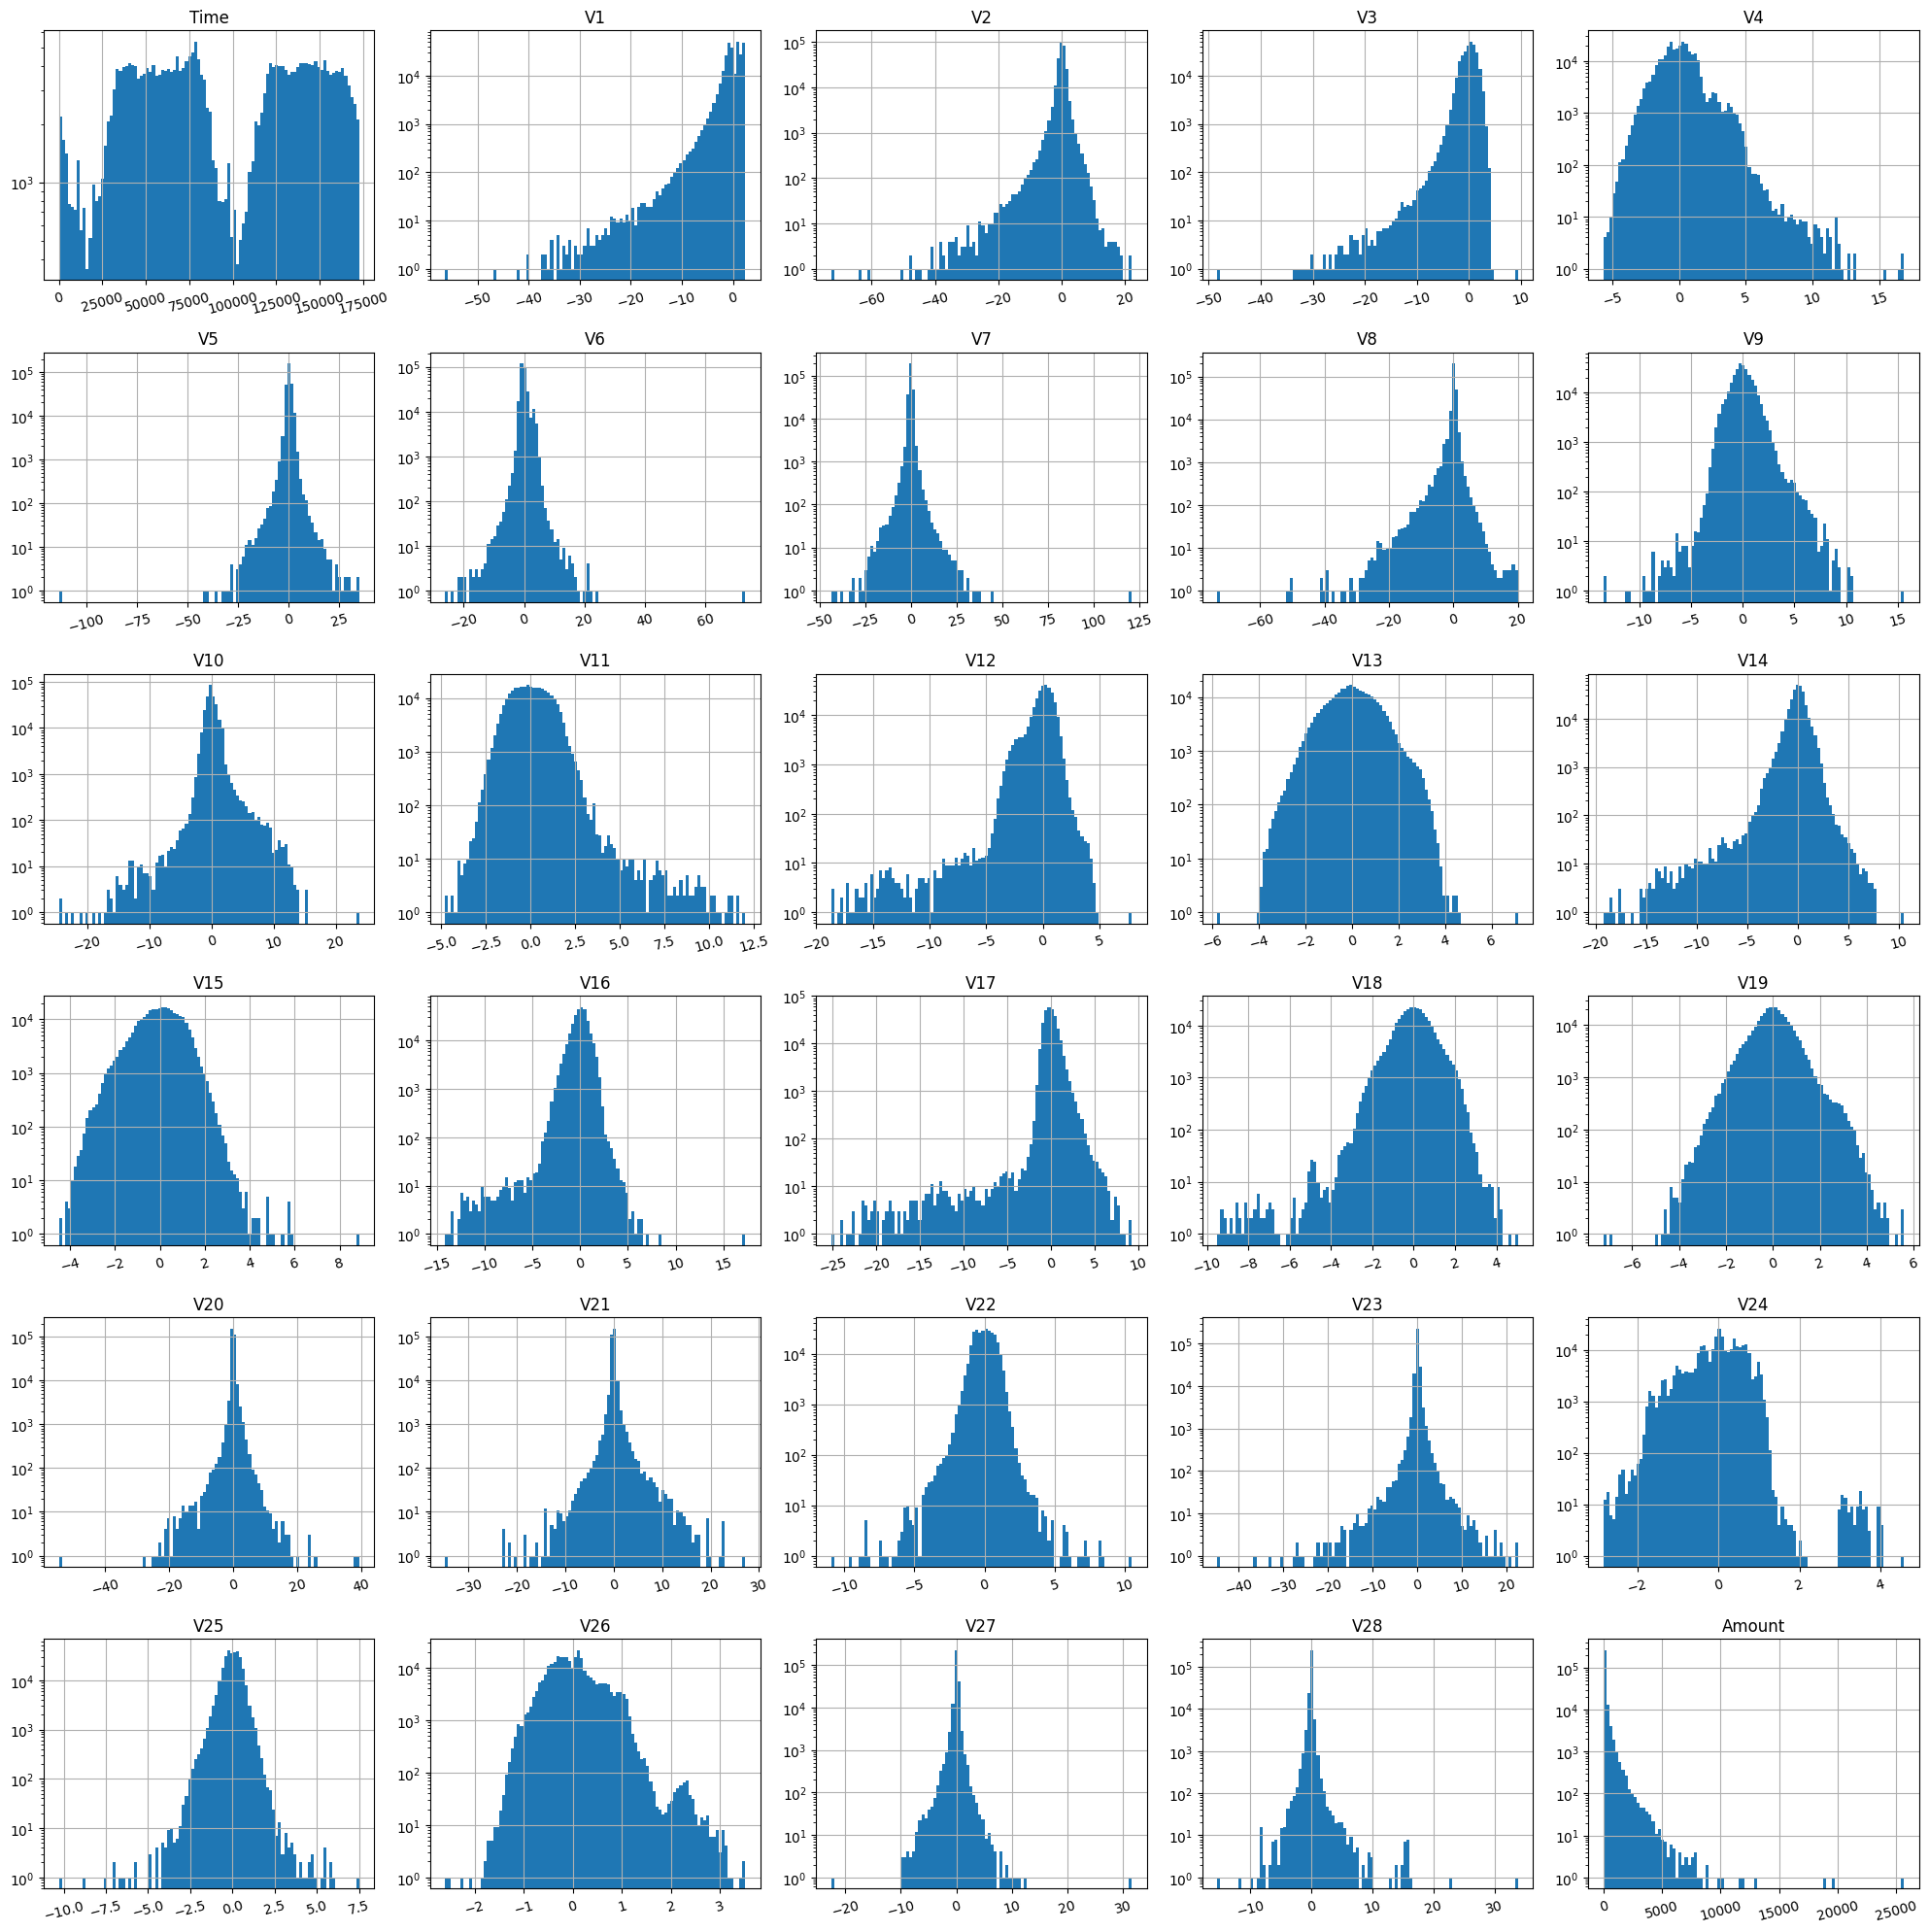

In [14]:
fig=plt.figure(figsize=(20,20))
for i, feat in enumerate(df.columns[:-1]):
    ax=fig.add_subplot(6,5,i+1)
    df[feat].hist(bins=100,ax=ax)
    ax.set_title(feat)
    ax.set_yscale('log')
    ax.tick_params(axis='x', labelrotation = 15)
fig.tight_layout()  
plt.show()


### 4.2 bivariate analysis

<Figure size 640x480 with 0 Axes>

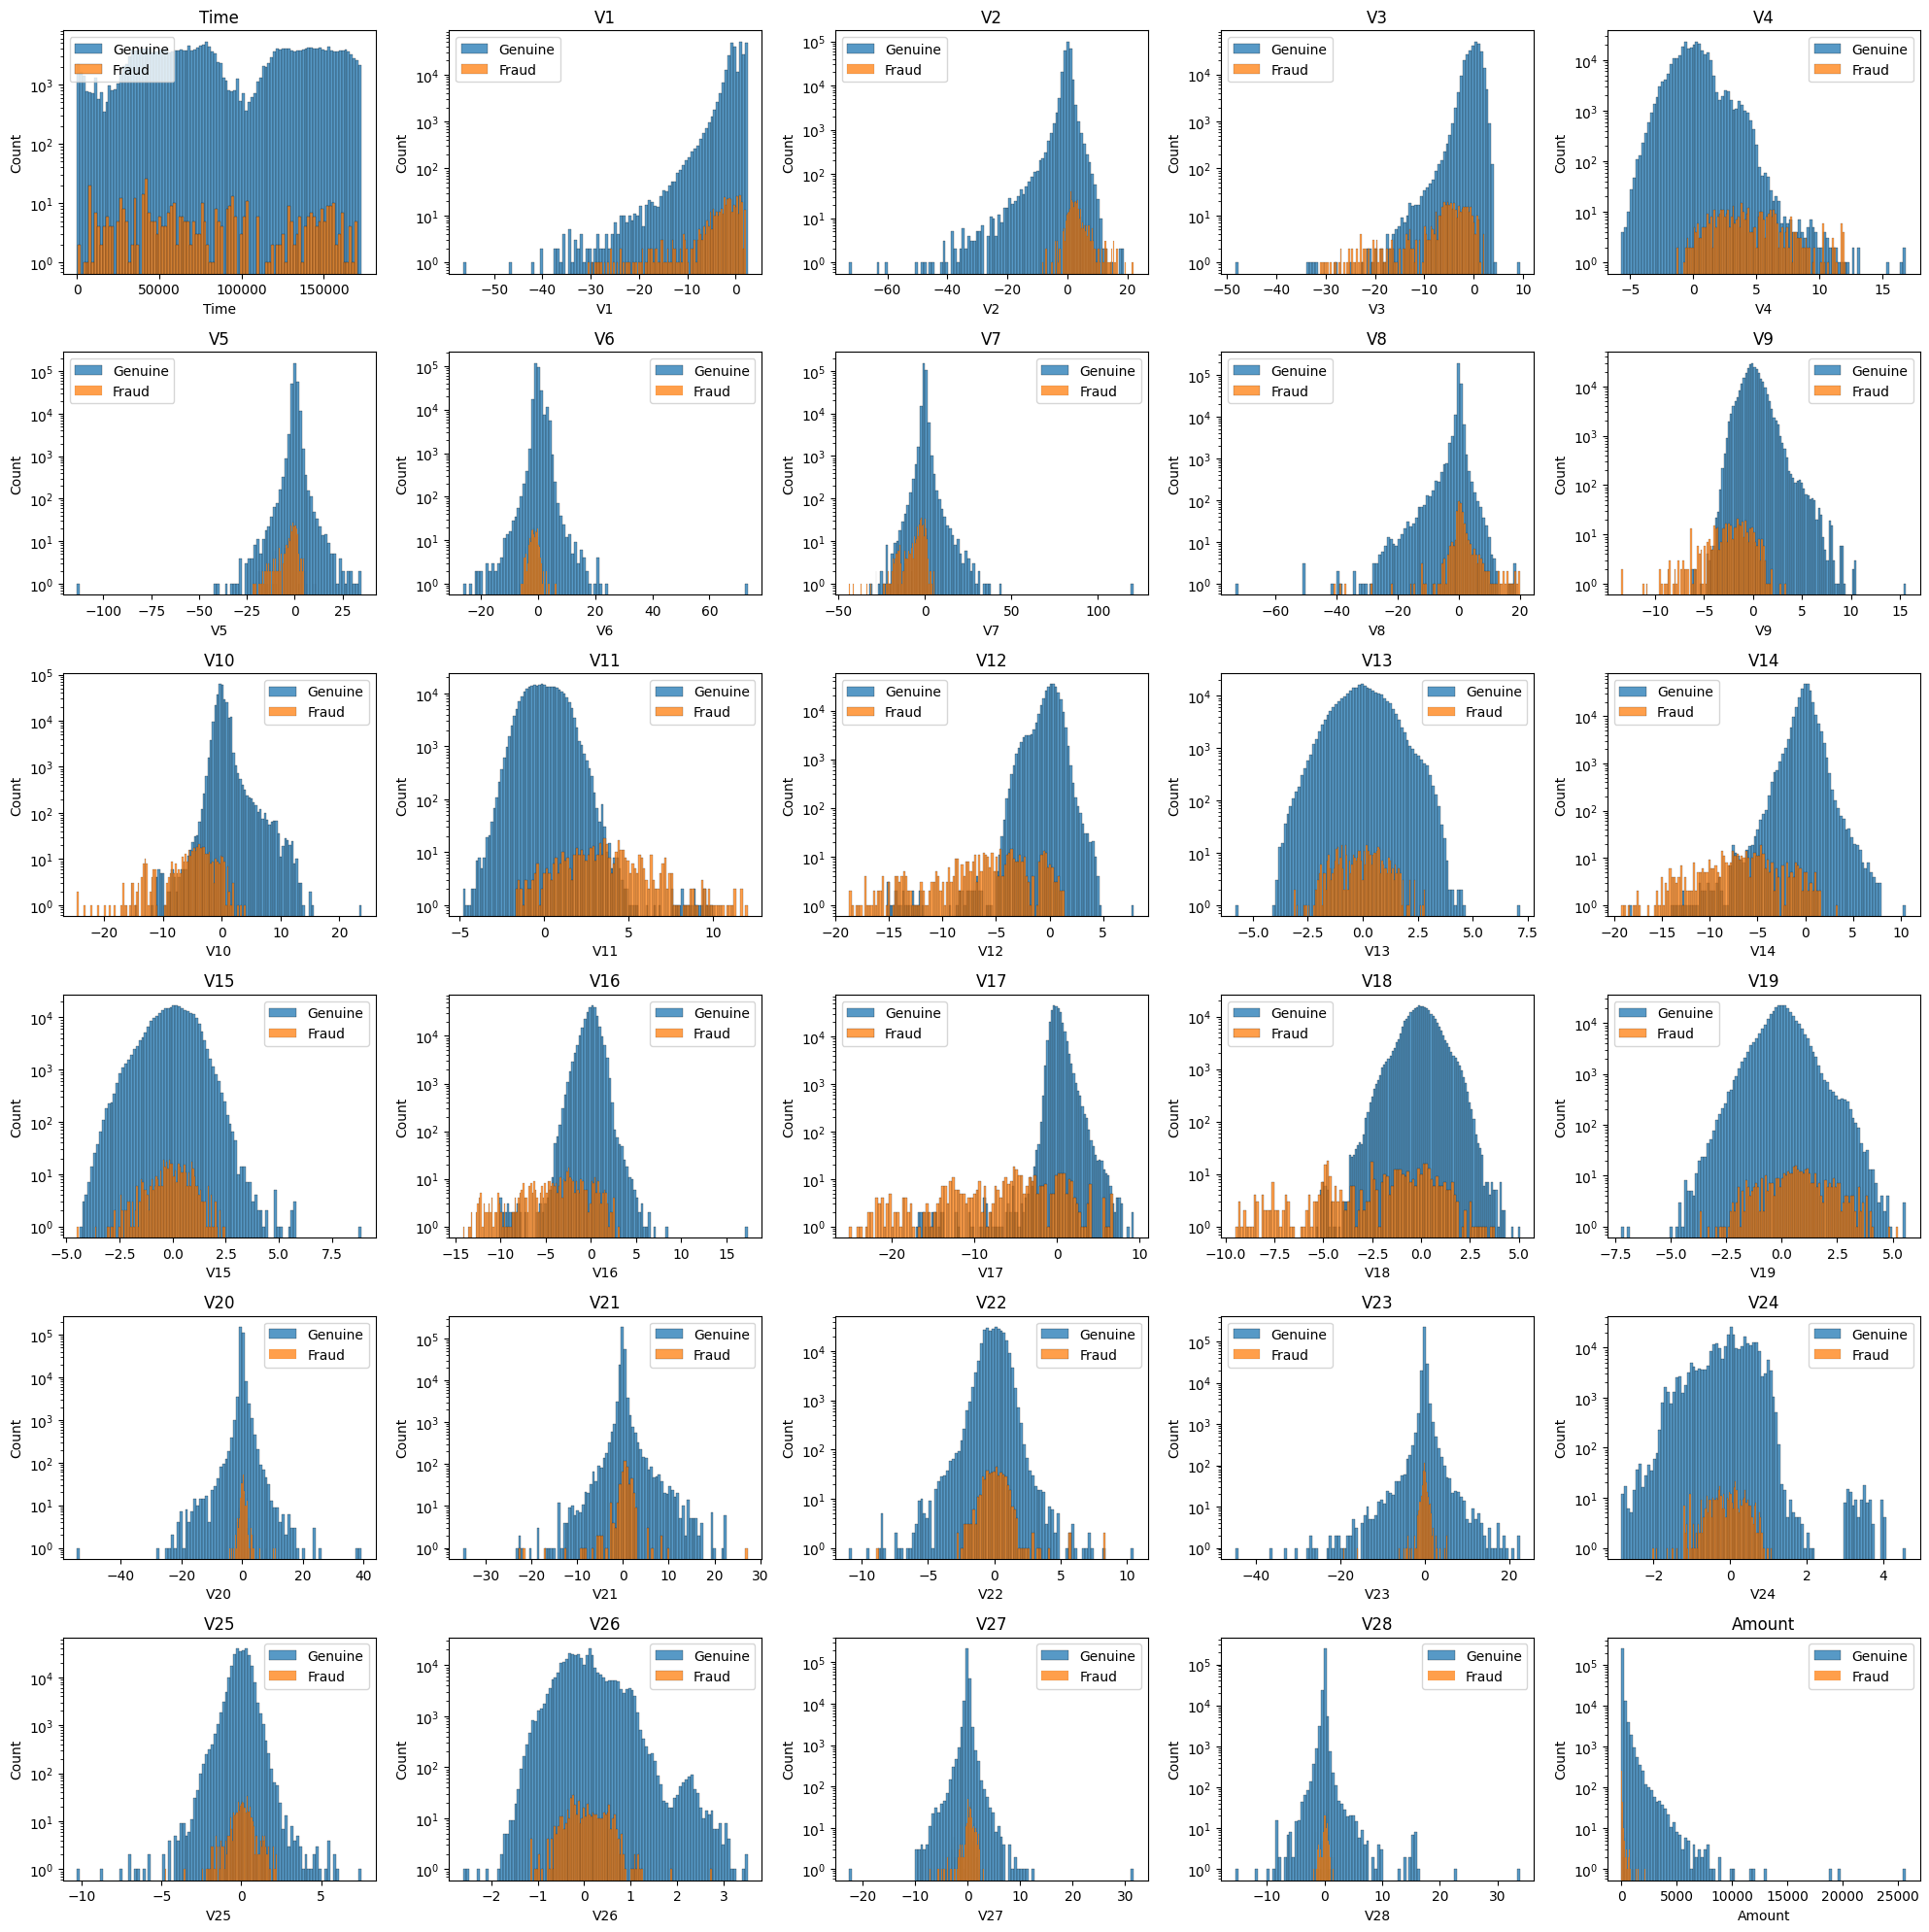

In [15]:
plt.figure()
fig, ax = plt.subplots(6,5,figsize=(20, 20))
i = 0
for feature in df.columns[:-1]:
    i += 1
    plt.subplot(6,5,i)
    sns.histplot(df[df['Class']==0][feature], bins=100, label="Genuine")
    sns.histplot(df[df['Class']==1][feature], bins=100, label="Fraud")
    plt.title(feature)
    plt.yscale('log')
    plt.legend()
fig.tight_layout() 
plt.show()

### 4.3 multivariate analysis

Text(0.5, 1.0, 'Correlation Matrix')

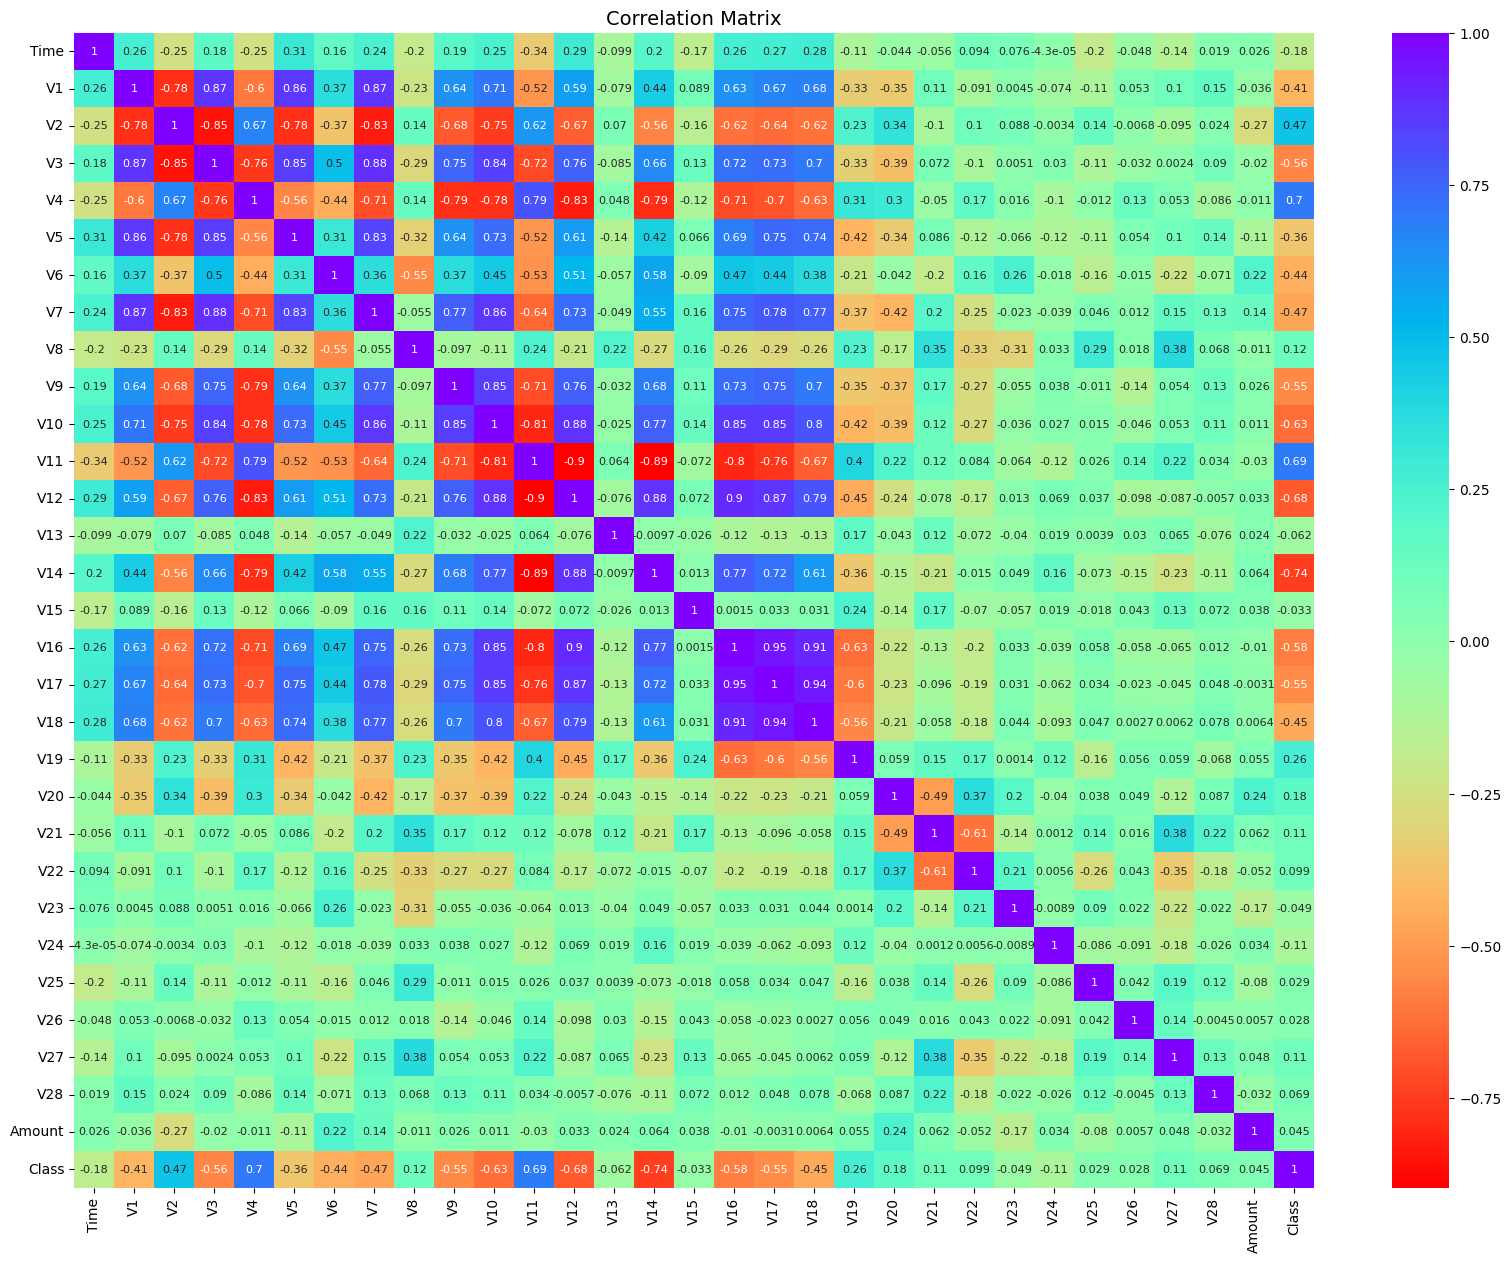

In [16]:
plt.figure(figsize=(20,15))
rus = RandomUnderSampler(random_state=42)
df_balanced = pd.concat([*rus.fit_resample(df[df.columns[:-1]], df["Class"])], axis=1)
corr = df_balanced.corr()
sns.heatmap(df_balanced.corr(), annot_kws={'size':8}, annot=True, cmap='rainbow_r')
plt.title("Correlation Matrix", fontsize=14)

## 5. model training and evaluation

### 5.1 train test split

#### 5.1.1 check if the dataset is sorted in increasing order of time

In [17]:
min(df.Time.diff().dropna())

0.0

#### 5.1.2 split dataset in time-series manner

In [18]:
split_index = int(len(df) * 0.8)
columns_to_select = sorted([c for c in df.columns if c not in ("Class", "Time")])
X, y = df[columns_to_select], df['Class']
X_train, X_test, y_train, y_test = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]

#### 5.1.3 ensure both train and test sets have similar fraud percentages

In [19]:
y_train.mean(), y_test.mean()

(0.0017578641289981497, 0.0013040566735981391)

### 5.2 handling class imbalance

In [20]:
smt = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [21]:
y_train.mean(), y_train_smt.mean()

(0.0017578641289981497, 0.5)

### 5.3 feature scaling

In [22]:
# initialize a MinMaxScaler object
scaler = MinMaxScaler()
# fit and transform the training set
X_train_scaled = scaler.fit_transform(X_train_smt)
# transform the testing set
X_test_scaled = scaler.transform(X_test)

In [23]:
pd.DataFrame(X_train_scaled, columns=columns_to_select).head()

,Amount,V1,V10,V11,V12,V13,V14,V15,V16,V17,...,V26,V27,V28,V3,V4,V5,V6,V7,V8,V9
0,0.007612,0.935192,0.510600,0.252484,0.680908,0.463328,0.635591,0.577952,0.609260,0.737173,...,0.394557,0.653816,0.256589,0.841021,0.313023,0.543337,0.546786,0.544502,0.786444,0.475312
1,0.000137,0.978542,0.505267,0.381188,0.744342,0.606220,0.641219,0.497308,0.650934,0.727794,...,0.446013,0.649710,0.257374,0.785989,0.271796,0.548514,0.535598,0.540544,0.786298,0.453981
2,0.019264,0.935217,0.513018,0.322422,0.706683,0.628245,0.640473,0.662961,0.501334,0.763381,...,0.402727,0.648375,0.255739,0.823300,0.268766,0.541195,0.574268,0.551363,0.788042,0.410603
3,0.006283,0.941878,0.507585,0.271817,0.710910,0.608021,0.636372,0.374593,0.582978,0.711253,...,0.389197,0.651776,0.258400,0.823759,0.213661,0.547600,0.562904,0.544478,0.789434,0.414999
4,0.003561,0.938617,0.524303,0.236355,0.724477,0.688911,0.608406,0.452712,0.610105,0.724243,...,0.507497,0.656289,0.261773,0.818086,0.269796,0.542442,0.539259,0.548895,0.782484,0.490950


### 5.4 training logistic regression model using random hyperparameter search with time-series splits-based k-fold cross validation

In [24]:
# Create a logistic regression model 
model = LogisticRegression() 

# Define the time series cross-validation strategy 
tscv = TimeSeriesSplit(n_splits=5) 

# Define the parameter space for the model 
param_space = {'C': uniform(0, 100), 'max_iter': randint(500, 5000)} 

# Create the RandomizedSearchCV object 
random_search = RandomizedSearchCV(model, param_distributions=param_space, n_iter=10, cv=tscv, random_state=42, scoring="average_precision") 

# Fit the random search object on the scaled training set 
random_search.fit(X_train_scaled, y_train_smt) 

# Print the best hyperparameters 
print('Best hyperparameters:', random_search.best_params_) 

# return the trained model 
best_model = random_search.best_estimator_ 

/Users/ashish.jha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best hyperparameters: {'C': 0.7066305219717406, 'max_iter': 3404}


### 5.5 evaluating model performance using precision recall curve

#### 5.5.1 plot precision-recall curve

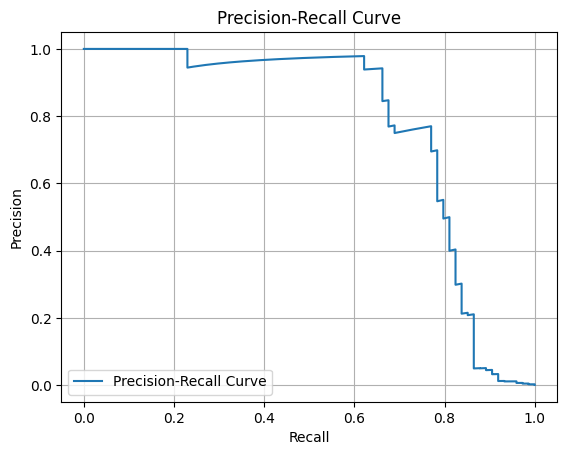

In [25]:
y_pred_prob = best_model.predict_proba(X_test_scaled)

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

#### 5.5.2 calculate area under PR curve (or average precision)

In [26]:
average_precision_score(y_test, y_pred_prob[:,1])

0.7728594441342731

#### 5.5.3 find recall and equivalent threshold at minimum 90% precision

In [27]:
for i, p in enumerate(precision):
    if p >= 0.9:
        break
# in case we land on a vertical line on PR curve, we can decrease the threshold further to increase precision at the same recall
for j, r in enumerate(recall):
    if r < recall[i]:
        print(f"precision={precision[j-1]}, recall={recall[j-1]}, at threshold={thresholds[j-1]}")
        break
threshold = thresholds[j-1]

precision=0.9423076923076923, recall=0.6621621621621622, at threshold=0.9999257352227462


#### 5.5.4 visualize optimal threshold point on PR curve

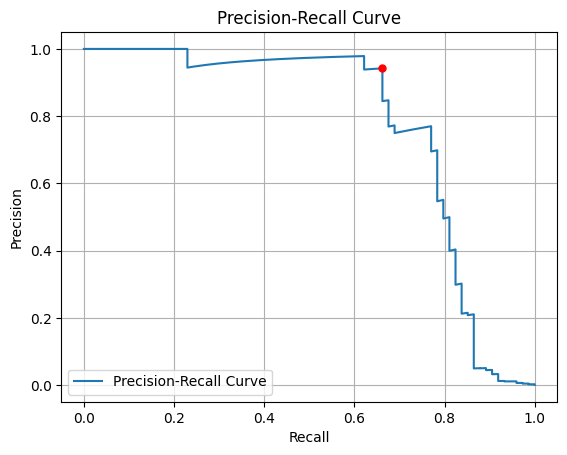

In [28]:
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.plot(recall[j-1], precision[j-1], marker='o', markersize=5, color="red");

## 6 Model interpretability

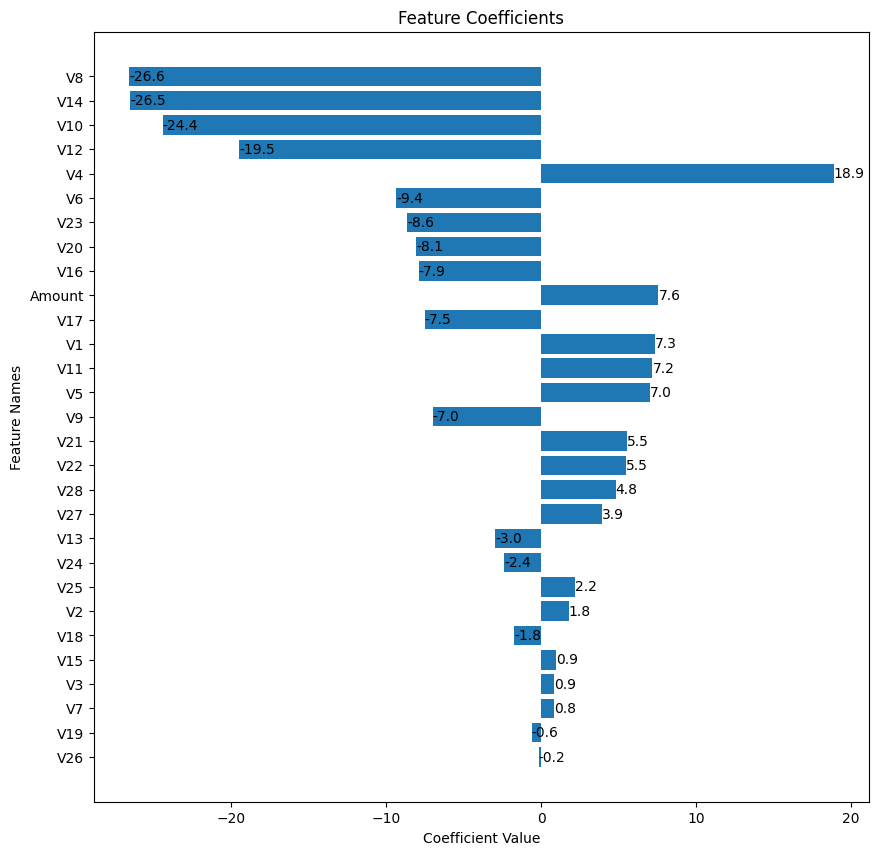

In [29]:
plt.figure(figsize=(10,10))
feature_coefficients = best_model.coef_[0]
feature_names = X_train.columns

sorted_features = sorted(zip(feature_names, feature_coefficients), key=lambda c: abs(c[1]))
sorted_names, sorted_coeffs = zip(*sorted_features)

plt.barh(range(len(sorted_coeffs)), sorted_coeffs, align='center')
for i, v in enumerate(sorted_coeffs):
    plt.text(v, i, str(round(v, 1)), va='center')
plt.yticks(range(len(sorted_coeffs)), sorted_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Names')
plt.title('Feature Coefficients')

plt.show()

## 7. Model deployment

### 7.1 Save model

In [30]:
# Save the trained model
model_artifact = {
    "scaler": scaler, 
    "logreg_model": best_model, 
    "logreg_model_threshold": threshold
}
joblib.dump(model_artifact, "model.joblib")

['model.joblib']

### 7.2 generate input payload from test data for model inference

In [31]:
json_payload = X_test.iloc[0].to_dict()
json_payload

{'Amount': 1.79,
 'V1': 0.142992201953079,
 'V10': -0.855008993686116,
 'V11': -0.591849419202952,
 'V12': 0.135208553083701,
 'V13': 0.466587931587459,
 'V14': -1.10494580299518,
 'V15': -0.239877723428563,
 'V16': 0.260985815816867,
 'V17': 0.384325447655063,
 'V18': -0.350801438237199,
 'V19': -0.290875252783854,
 'V2': 1.06540505706892,
 'V20': 0.0398899468832053,
 'V21': -0.333581863108201,
 'V22': -0.779618333308082,
 'V23': 0.089250169042436,
 'V24': 0.512206931953748,
 'V25': -0.416654233038179,
 'V26': 0.117893068769471,
 'V27': 0.228983572496098,
 'V28': 0.0843445937999741,
 'V3': -0.407431623326328,
 'V4': -0.562354885314715,
 'V5': 1.00179051170196,
 'V6': -0.726233416127765,
 'V7': 0.987183491731403,
 'V8': -0.108878671343682,
 'V9': -0.115907938884984}

In [32]:
with open("./test_payload.json", "w") as f:
    json.dump(json_payload, f)

### 7.3 load model and make predictions

please refer to the python script model_server.py for this code

In [33]:
1

1